# Exercise 2 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2024/25

 * Lecture by: Constantin Pape

 * Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair

 * Due date: **Tuesday, Nov 19, before 10:00**

### Time required to solve this exercise sheet

**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics



In this exercise sheet, you will:

- work again with CIFAR-10

- implement a 1-layer CNN

- compare MLP and CNN

- vary architecture to improve model performance

- implement a ResNet for CIFAR-10

- learn about learning rate scheduling



*We are looking forward to seeing your solutions! Have fun!*

## IMPORTANT SUBMISSION INSTRUCTIONS



- **You need to answer all questions in written form!**

- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`

- Only submit the Jupyter Notebook (.ipynb file). No other file is required.

    - Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 2` -> `Tutorial X` (where, X is the tutorial you are assigned to).

- Make only one submission of the exercise per group.

- The deadline is strict.

- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand



Implementation:

- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs for the questions asked.

### Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

## 1. Setup



You can use the functions to grab the data, split the sets, create the dataloaders and plot results, etc. given to you at exercise sheet 1.



It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.



If you work with Kaggle (recommended) you have to mount the drive first and create a path to your python module or download the file from your drive.

#### **TODO**

Create a file named `setup.py` with all the necessary functions. Download this file to your Kaggle workspace and import it on this notebook.



Hint: Use the package `gdown` to download files from google drive.



```python

!conda install -y gdown

!gdown <file_id>

```



Here's how to find the `file_id`: 

If the file URL is https://drive.google.com/file/d/1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk/view?usp=share_link



where, `file_id` is 2732jDmxp7fXwddNGj8h0CWJA0WWLpvKk

In [3]:
# TODO: Download setup.py from google drive in Kaggle

!conda install -y gdown

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.9.2               |  py310hff52083_0         895 KB  conda-forge
    filelock-3.16.1            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.4.0              |       hb9d3cd8_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.16.1-pyhd8ed1ab_0 
  gdown              conda-forg

In [4]:
# TODO: Import setup.py
import gdown
file_id = '12G5ZNJovF2PfjB8nNqmtJ7kJCpEss3Qb'
file_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(file_url, "func.py", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=12G5ZNJovF2PfjB8nNqmtJ7kJCpEss3Qb
From (redirected): https://drive.google.com/uc?id=12G5ZNJovF2PfjB8nNqmtJ7kJCpEss3Qb&confirm=t&uuid=4b6fa360-2e26-4cf4-8d24-e8f4998a8fdc
To: /kaggle/working/func.py
100%|██████████| 11.9k/11.9k [00:00<00:00, 17.0MB/s]


'func.py'

## 2. Load dataset, create dataloader, etc.



#### **TODO**

Call the functions of `setup.py` to instantiate the train-, test- and validation datasets along with their dataloaders.

In [5]:
import pathlib
data_dir = pathlib.Path("data/")
cifar = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)

100%|██████████| 170498071/170498071 [00:12<00:00, 13520061.33it/s]


Extracting data/cifar-10-python.tar.gz to data


In [6]:
import func 
import os

In [7]:
# TODO: Define device
device = func.get_device()

num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 2
Using device Tesla T4
4 CPUs available


In [8]:
def grab_data(data_dir, num_cpus=1):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(
        data_dir, train=True, download=True, transform=torchvision.transforms.ToTensor()
    )

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=num_samples, num_workers=num_cpus
    )
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(
        data_dir, download=True, train=True, transform=normalized_transform
    )

    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(
        data_dir, download=True, train=False, transform=normalized_transform
    )

    return trainset, testset, dataset_mean, dataset_std

In [9]:
data_dir = 'data'
random_seed = 42
batch_size = 256

trainset, testset, dataset_mean, dataset_std = grab_data(data_dir, num_cpus=1)
trainset, valset = func.generate_train_val_data_split(trainset, split_seed=random_seed, val_frac=0.2)
trainloader, valloader, testloader = func.init_data_loaders(trainset, 
                                                       valset, 
                                                       testset, 
                                                       batch_size=batch_size, 
                                                       num_cpus=1)


# TODO: Grab data, generate split and initialize data loaders

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 

Define the loss function. We use the cross entropy loss again.

In [36]:
# TODO: Define loss function
loss_function = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**

- Define the model.



The first step to training a model is defining its architecture. 

Define a sequential model with following structure:

*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.

*   Max Pooling layer with kernel size of 2*2 and default stride.

*   ReLU Activation Layers.

*   Linear layer with output of 512.

*   ReLU Activation Layers.

*   A linear layer with output of 10.

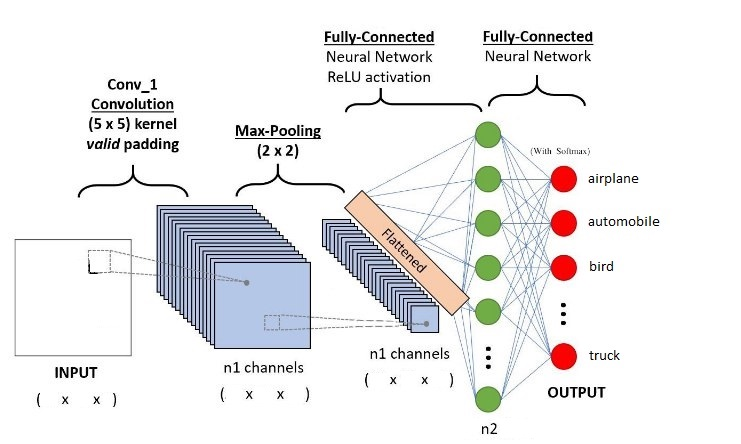

In [37]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 10):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size = 5, stride=1),
            nn.MaxPool2d(2),
            nn.ReLU())

        self.linear = nn.Sequential(
            nn.Linear(32*14*14, 512),
            nn.ReLU(),
            nn.Linear(512, out_channels))

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x , start_dim = 1, end_dim = 3)
        x = self.linear(x)
        return x


#### **Questions**

Sizes given in (batch_size, channels, width, height)

- What are the input dimensions?

  **256x3x32x32, No computation is needed for this step; it’s the starting point.**

- What are the dimensions of the feature maps?

  **256x32x28x28,Output Size (Width/Height) = ((Input Size - Kernel Size + 2 . Padding) / Stride) + 1,  We have 32 filters, conv layer with kernel 5 and stride 1 results to 32 -> 28**

- What are the dimensions after pooling?

  **256x32x14x14, Pooling reduces the spatial dimensions using a fixed operation Output Size (Width/Height) = ((Input Size - Kernel Size)/ Stride)+ 1, Max poling with kernel 2 takes only one value from square 2x2 so size reduce twice 28 -> 14**

- What is the size of each input (i.e value of `in_features`) to the first fully connected linear layer?

    **in_linear_features = 32\*14\*14 = 6272, A fully connected layer expects a flat vector as input, so we flatten the feature map by multiplying all its dimensions (except the batch size). Flattened Input Size = Number of Filters \* Width\* Height**

- What is the number of parameters for conv_1?

  **32(filters)\*3(in channels)\*5\*5(kernel size)=2400, Number of Parameters = (Kernel Width \* Kernel Height \* Input Channels + 1) \* Number of Filters**

**Your answers here**

In [38]:
# TODO: Define model
simple_conv_model = SimpleCNN().to(device)

#### **TODO**



- Train the model for 10 epochs. Try lr=0.001 (can be changed to suit other design choices you make)

- Plot the results of accuracy and loss as you did in exercise sheet 1.

In [39]:
# TODO: Train and plot
num_epochs = 10
optimizer = optim.Adam(simple_conv_model.parameters(), lr = 0.001)
    
train_losses, val_losses, train_accs, val_accs, confusion_matrix = func.run_training(simple_conv_model, 
            optimizer, 
            loss_function, 
            device, 
            num_epochs, 
            train_dataloader = trainloader, 
            val_dataloader = valloader, 
            early_stopper=None, 
            verbose=False)

Finished training after 116 seconds.


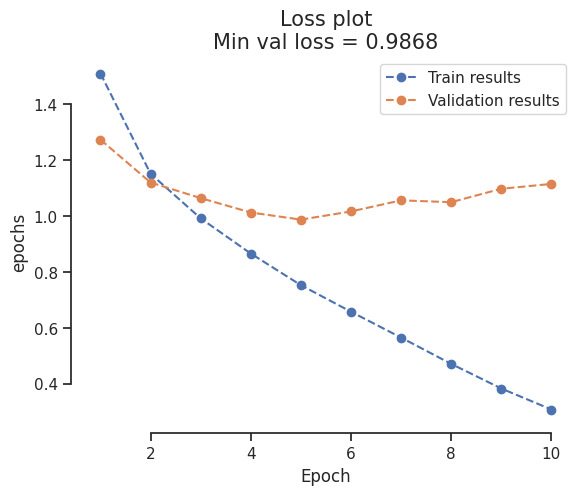

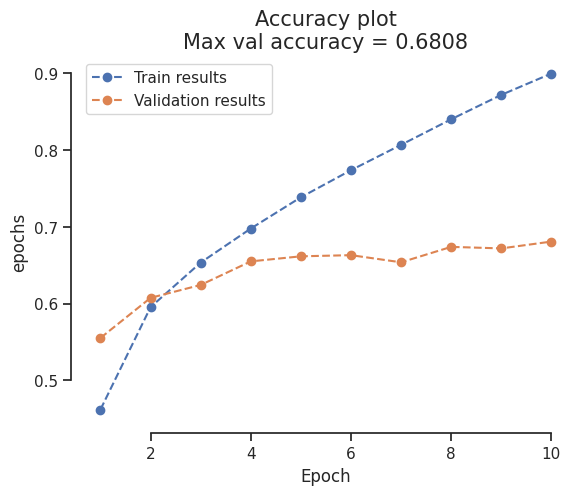

In [40]:
func.plot(f'Loss plot\nMin val loss = {round(min(val_losses),4)}' ,'epochs', 
     train_losses, val_losses)

func.plot(f'Accuracy plot\nMax val accuracy = {max(val_accs)}' ,'epochs', 
     train_accs, val_accs)

#### **TODO**

Compare results to the MLP models you trained in Exercise 1. What can you observe?

**Your answers here**

Compared to the MLP model, this CNN achieves higher validation accuracy and learns faster, quickly approaching an accuracy of 1 on the training data. This improvement shows that the CNN captures spatial features more effectively than the MLP, which couldn't achieve such high accuracy even on training data. However, the CNN also overfits faster, so we should be aware of this and always keep in mind that some regularization techniques may be necessary to improve generalization.

**For your reference, below is the loss and accuracy plots of an MLP model trained in Exercise sheet 1:**

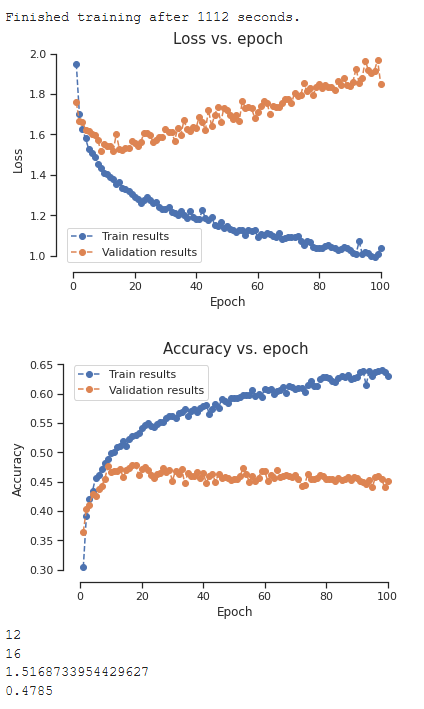

#### **TODO** 

Train longer (ca. 60 epochs), plot again.

In [14]:
# TODO: Train and plot
simple_conv_model = SimpleCNN().to(device)
num_epochs = 60
optimizer = optim.Adam(simple_conv_model.parameters(), lr = 0.001)
    
train_losses, val_losses, train_accs, val_accs, confusion_matrix = func.run_training(simple_conv_model, 
            optimizer, 
            loss_function, 
            device, 
            num_epochs, 
            train_dataloader = trainloader, 
            val_dataloader = valloader, 
            early_stopper=None, 
            verbose=False)

Finished training after 720 seconds.


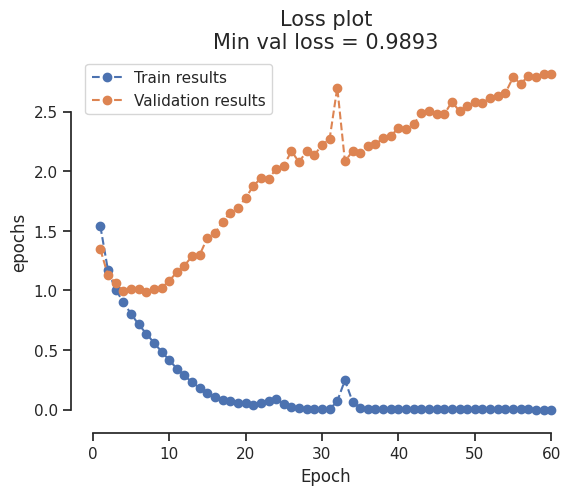

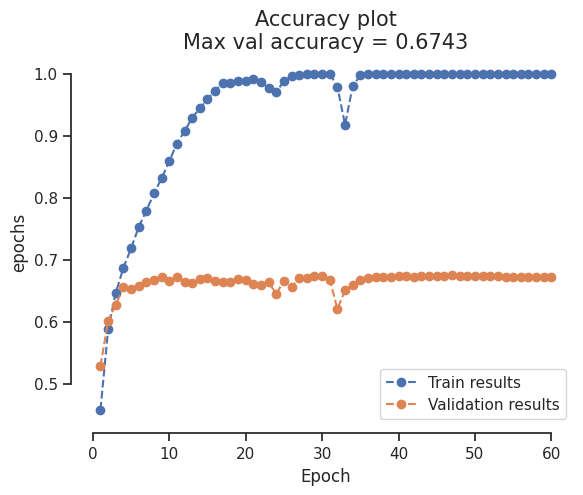

In [15]:
func.plot(f'Loss plot\nMin val loss = {round(min(val_losses),4)}' ,'epochs', 
     train_losses, val_losses)

func.plot(f'Accuracy plot\nMax val accuracy = {max(val_accs)}' ,'epochs', 
     train_accs, val_accs)

#### **Questions**

- Why is that not an optimal model?

- What could be improved?

**Your answers here**

This simple model overfits quickly, reaching an accuracy of 1 on training data but showing increasing validation loss. With only one convolutional layer, it captures basic features (like edges) but misses more complex patterns, limiting its ability to generalize well. Training for too many epochs also could lead to overfitting, as the model has time to memorize the data instead of generalizing. With small models, overfitting might occur sooner since it takes less time for them to fully capture patterns in a limited dataset.

Adding more convolutional layers would help the model learn complex features, improving performance and prevent fast overfitting. Dropout and batch normalization could also boost stability. 

## 4. CNN model with more convolutional layers

#### **TODO**

Define the architecture using the following information:







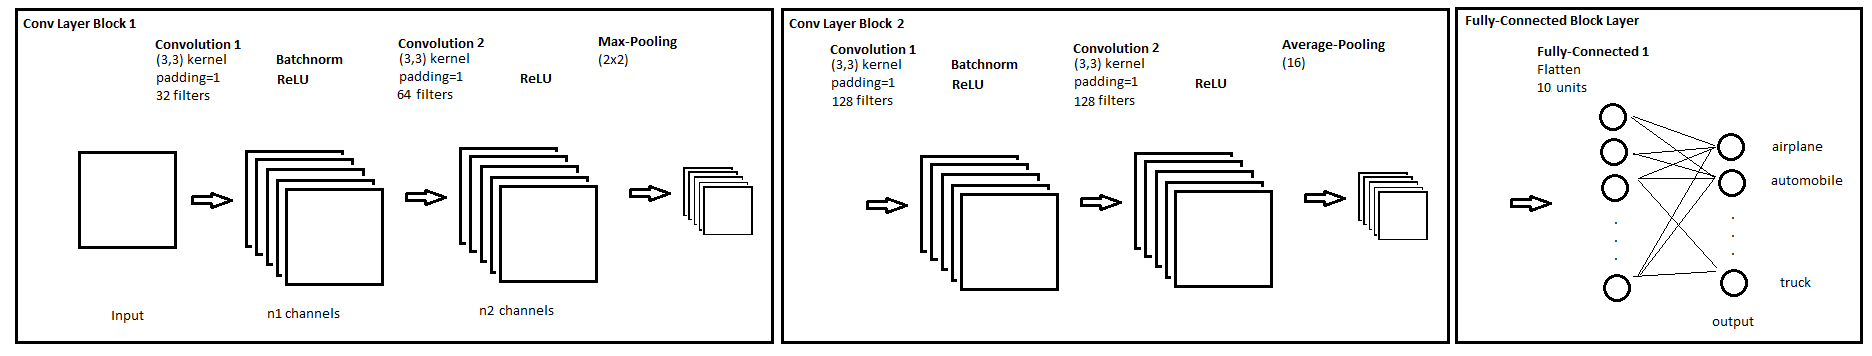

*   Convolutional layer 1: with 32 filters, kernel size of 3*3 and padding 1.

*   Batchnorm and ReLU layers

*   Convolutional layer 2: with 64 filters, kernel size of 3*3 and padding 1.

*   ReLU Activation layer

*   Max pooling with kernel size of 2*2 **32 -> 16**

*   Convolutional layer 3: with 128 filters, kernel size of 3*3 and padding 1.

*   Batchnorm and ReLU layers

*   Convolutional layer 4: with 128 filters, kernel size of 3*3 and padding 1.

*   ReLU Activation layer

*   Average pooling with kernel size 16*16

*   Fully connected layer

#### **Questions**



- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps? **Padding in convolutional layers involves adding a border (or frame) of values (usually zeros) around the input image or feature map. This technique is used to control the spatial dimensions of the output feature map after applying the convolution operation.**

- What does padding=1 mean in the case of the network displayed above? **Padding = 1 means a 1-pixel-wide frame of zeros is added around the edges of the input feature map, preserving its spatial dimensions after convolution.**

- What are the dimensions of the feature maps after the 1. conv layer? **256x32x32x32 (batch size x filters x height x width), given 32 filters and "same" padding**

- What are the dimensions of the feature maps after the 2. conv layer? **256x64x32x32 (batch size x filters x height x width), given 64 filters and "same" padding.**

- What ist the receptive field size after the first two convolutions? **The receptive field size after two 3x3 convolutions is 5x5 (see picture)**

- What is the value for the in_features for the fully-connected layer? **128\*1\*1**

- What is the number of parameters of *Conv Layer block 1*? **32(filters)\*3(in channels)\*3\*3(kernel size)=864**

**Your answers here**

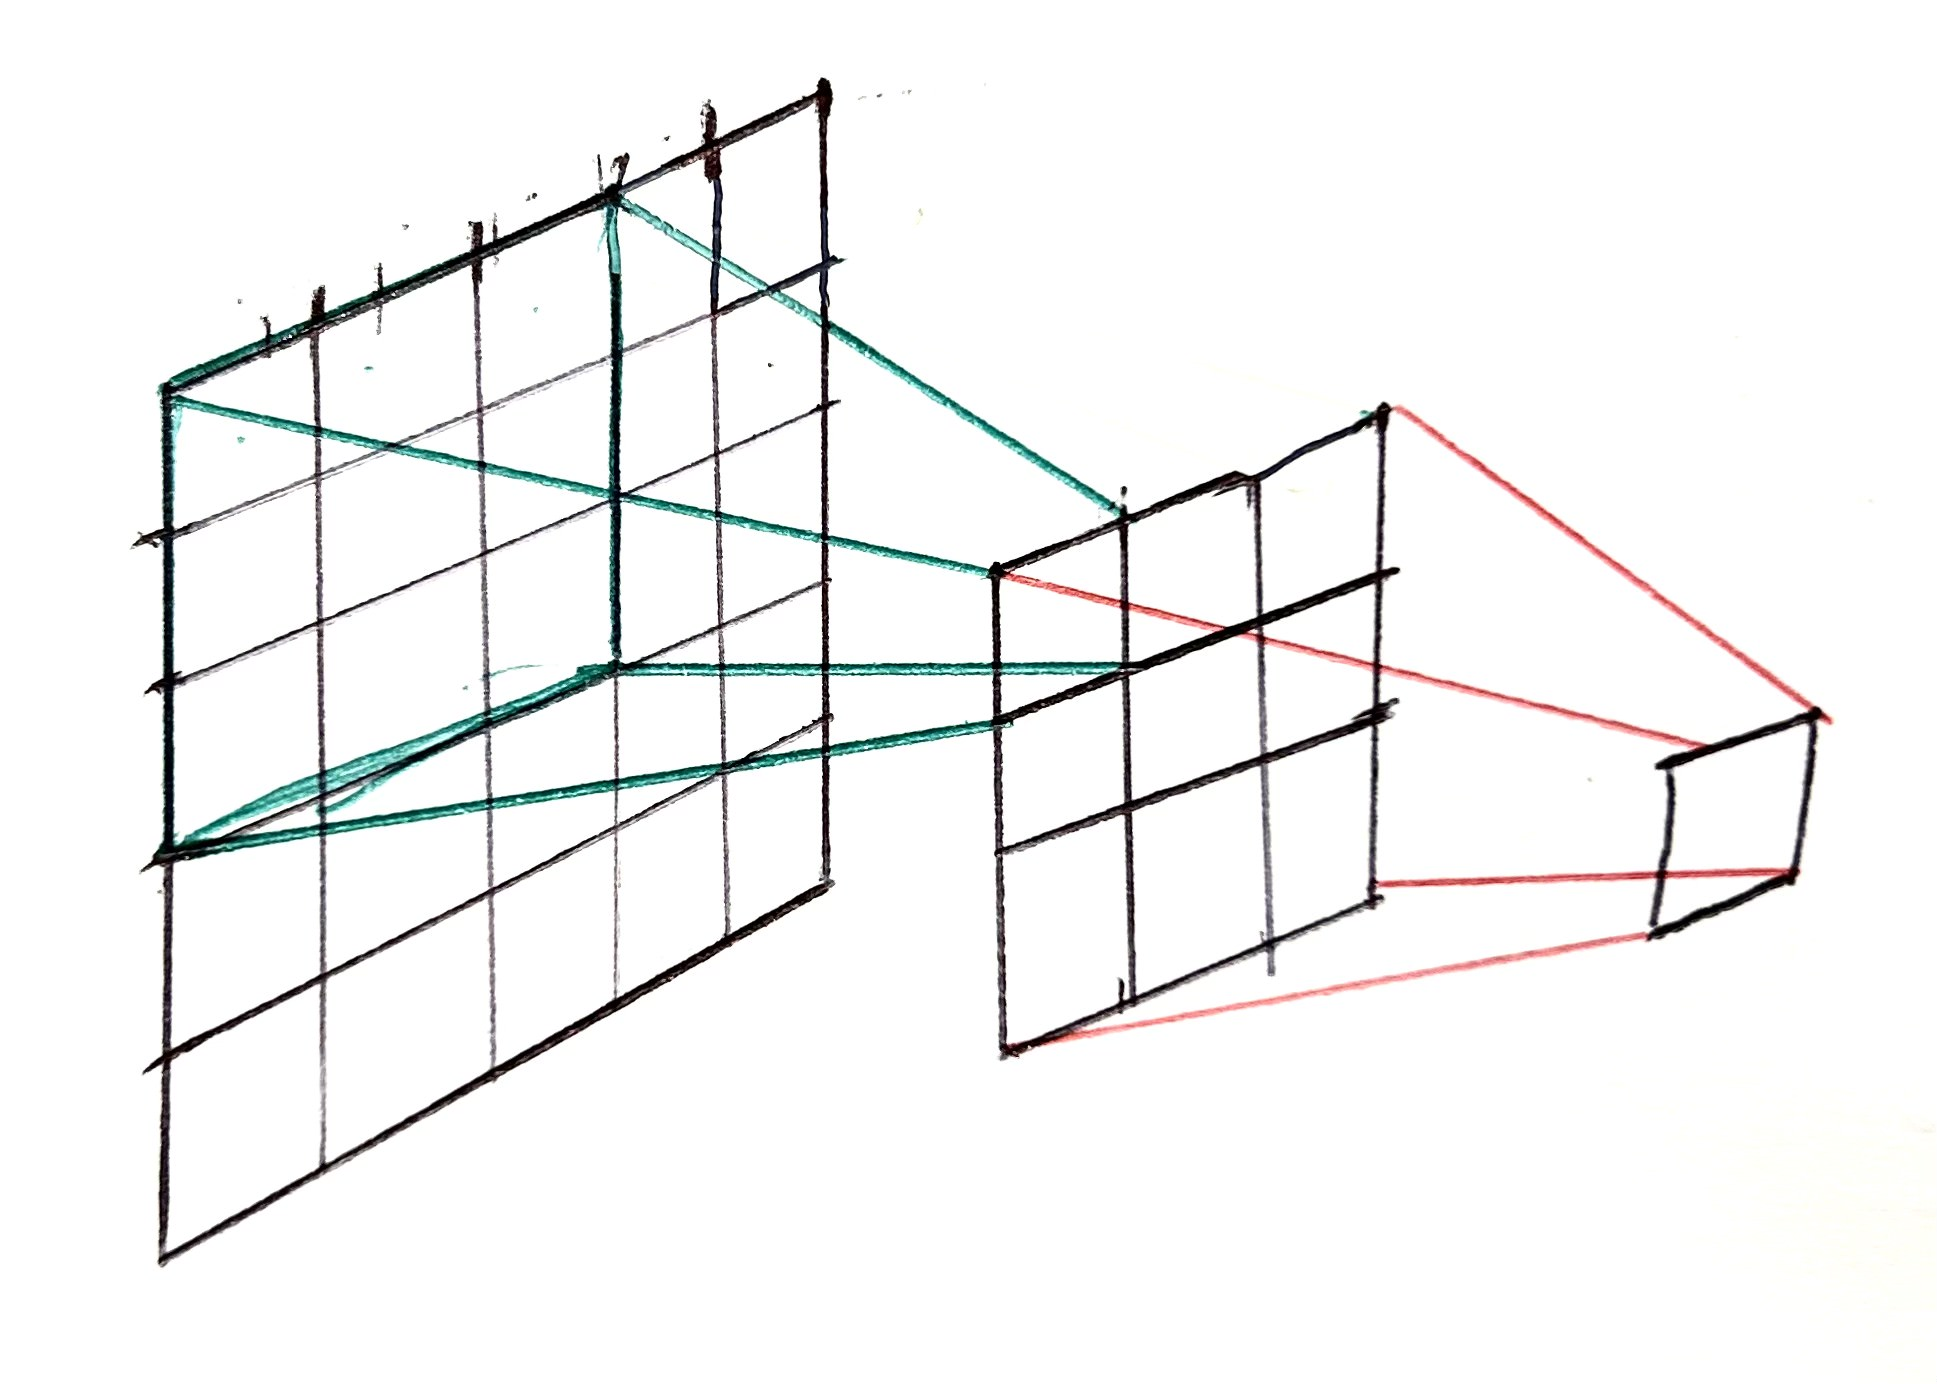



In [49]:
#TODO: Define model 2
class CNN_Model(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 10):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size = 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, padding=1),
            nn.ReLU())
        
        self.max_pooling = nn.MaxPool2d(2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size = 3, padding=1),
            nn.ReLU())
        
        self.avg_poooling = nn.AvgPool2d(16)

        self.linear = nn.Linear(128, out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.max_pooling(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avg_poooling(x)
        x = torch.squeeze(x)
        #x = torch.flatten(x , start_dim = 1, end_dim = 3)
        x = self.linear(x)
        return x

#### **TODO** 



- train the new net (30 epochs, try lr=0.1 or change as necessary), plot the results, and compare the results to the 1-layer CNN

- explain why you observe these results

In [54]:
cnn_model = CNN_Model().to(device)
num_epochs = 30
optimizer = optim.Adam(cnn_model.parameters(), lr = 0.01)
    
train_losses, val_losses, train_accs, val_accs, confusion_matrix = func.run_training(cnn_model, 
            optimizer, 
            loss_function, 
            device, 
            num_epochs, 
            train_dataloader = trainloader, 
            val_dataloader = valloader, 
            early_stopper=None, 
            verbose=False)

Finished training after 357 seconds.


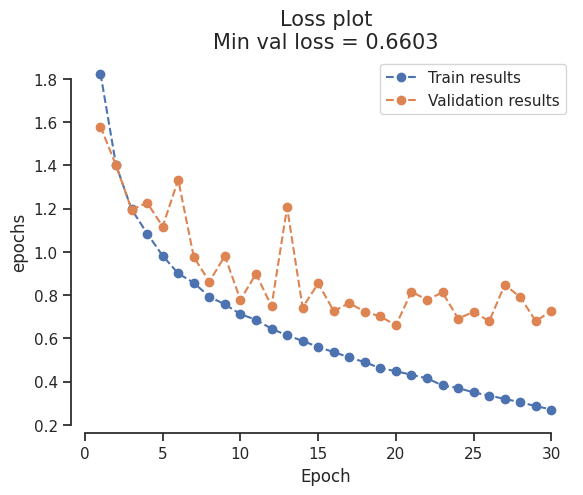

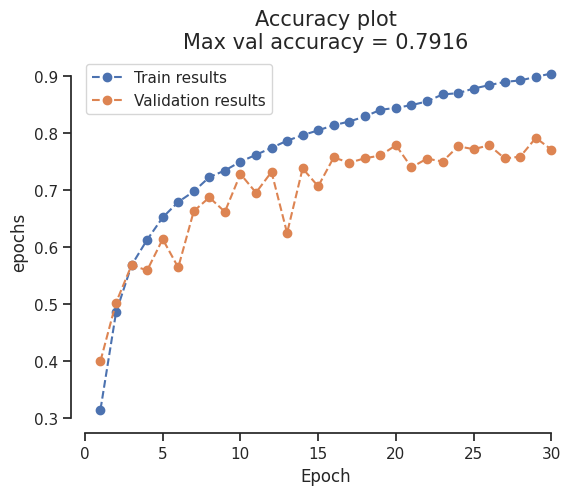

In [56]:
func.plot(f'Loss plot\nMin val loss = {round(min(val_losses),4)}' ,'epochs', 
     train_losses, val_losses)

func.plot(f'Accuracy plot\nMax val accuracy = {max(val_accs)}' ,'epochs', 
     train_accs, val_accs)

In [19]:
# TODO: Train and plot

Compare to 1 layer CNN we do not see fast overfitting and we do see higher accurasy on validation data, although our model has a relatively large number of filters (128 channels in the third and fourth layers) and only one fully connected layer, it may be memorizing patterns rather than generalizing. This overfitting can cause fluctuations in validation accuracy as the model learns specific details from the training data that don't generalize to new data.

Interestingly, with a smaller learning rate, the model may experience larger fluctuations and lower accuracy. This can be caused by the model getting "stuck" in poor local minima or making very slow progress toward better solutions.

### Learning rate 0.001
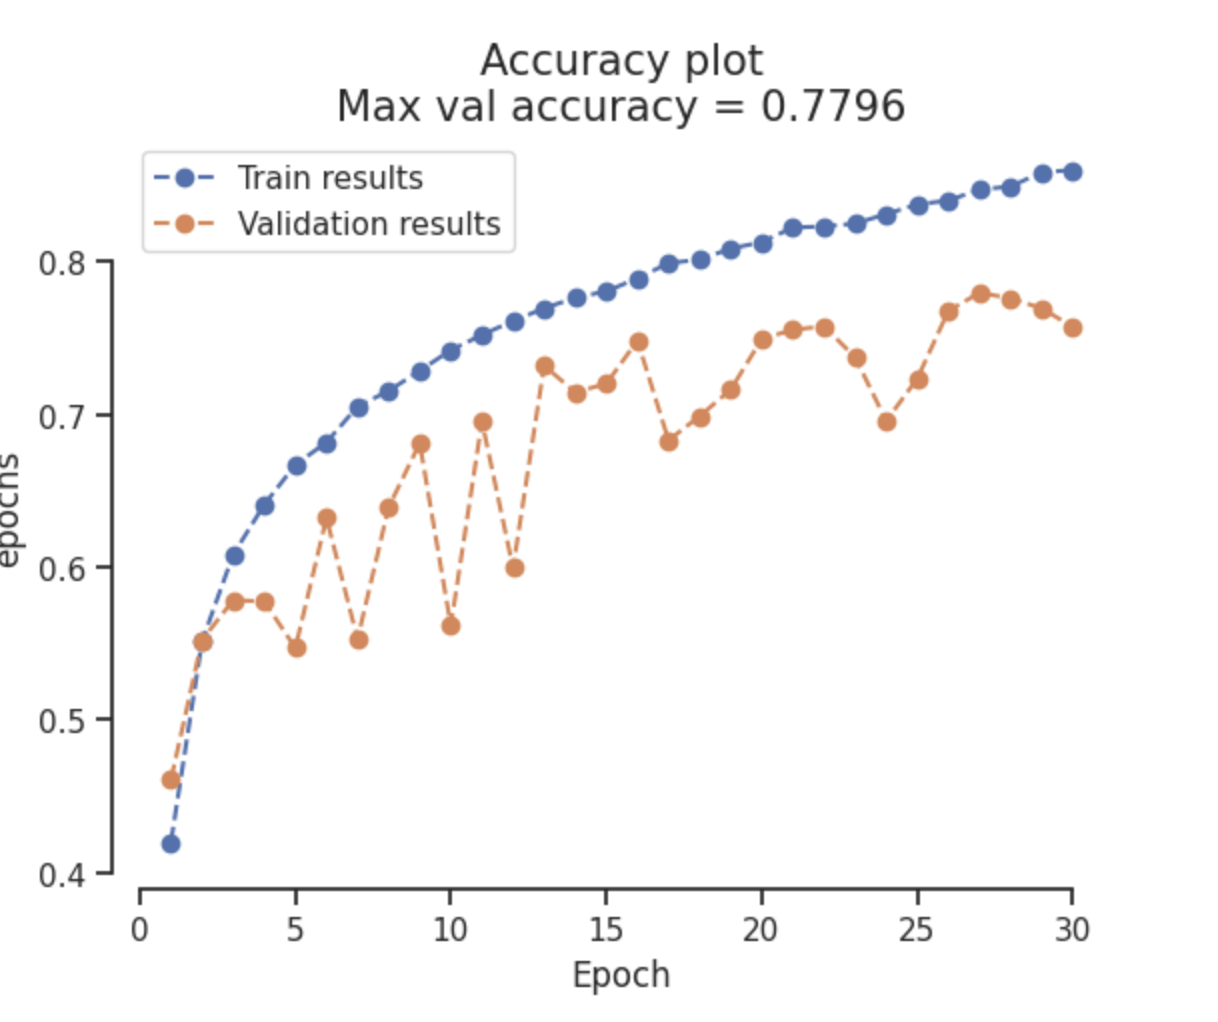

### Learning rate 0.01

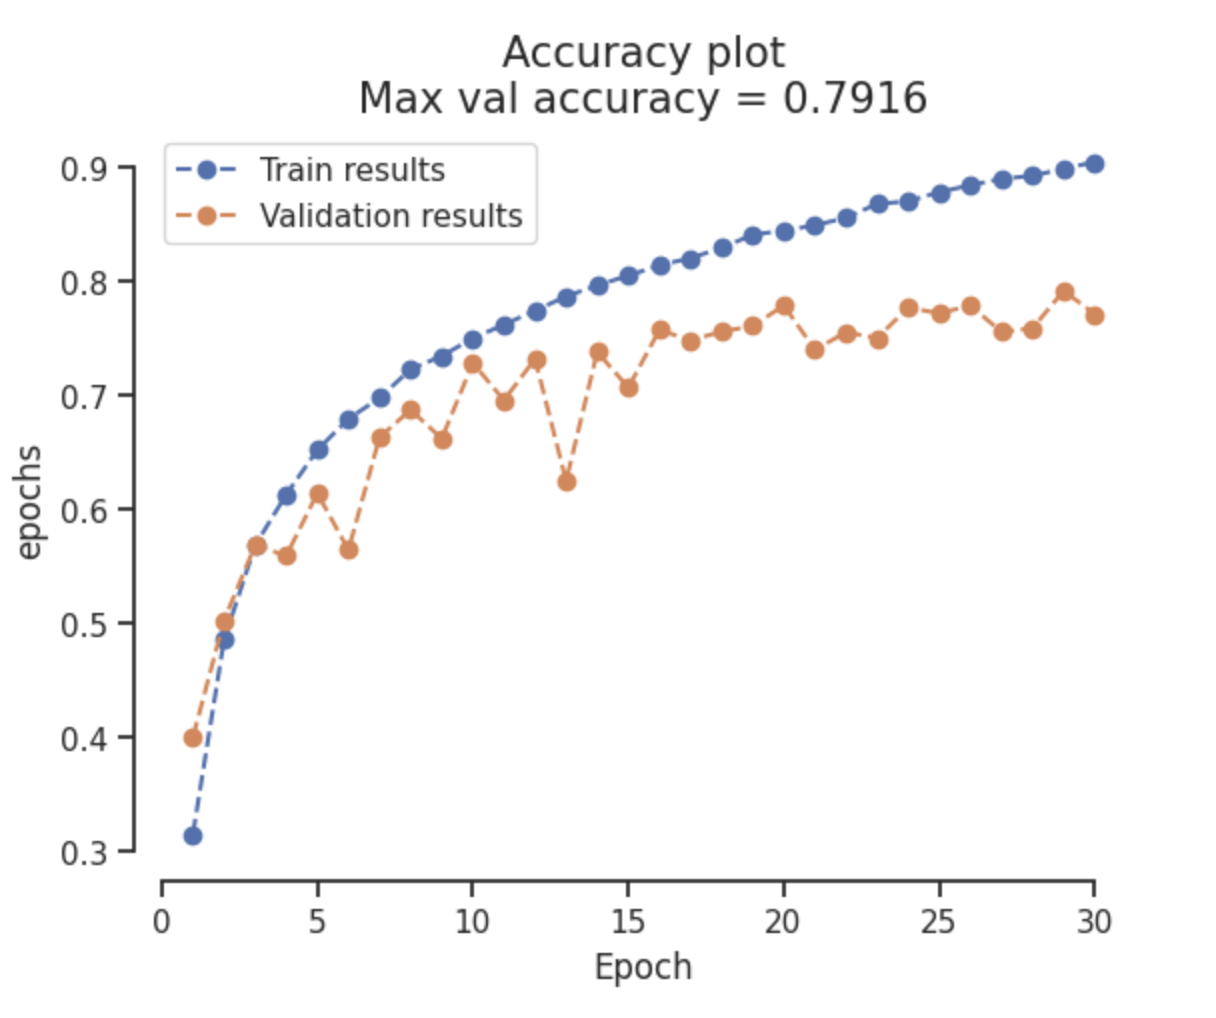

### Learning rate 0.1
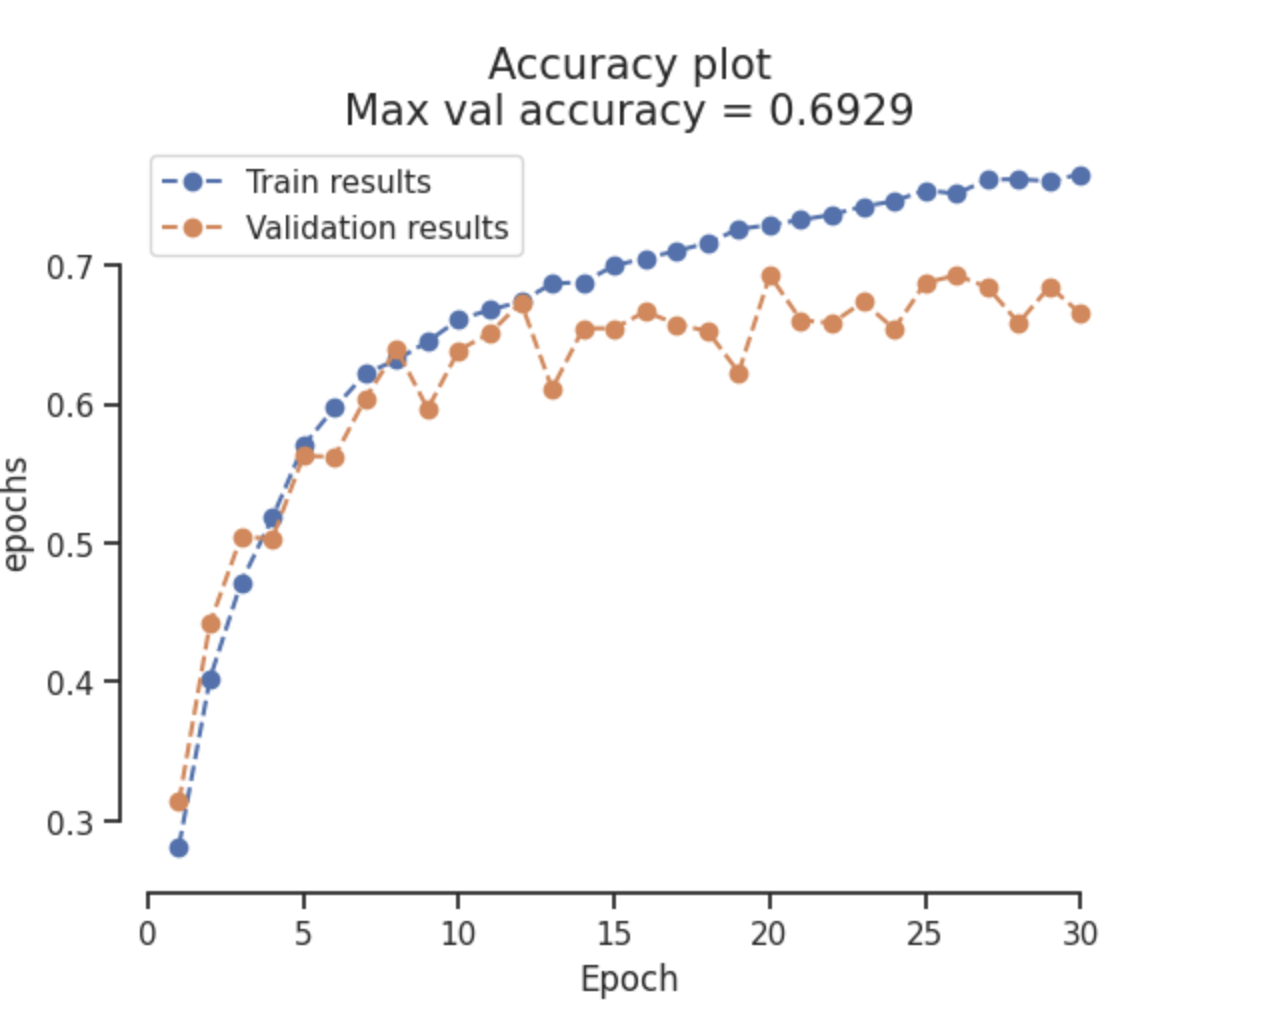

## 5. ResNet architecture



"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]



That was the intention of He et al. to develop residual networks.



A ResNet is built of blocks which are called the *Residual Blocks*. 

A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.

The Resnet skips connections via addition.



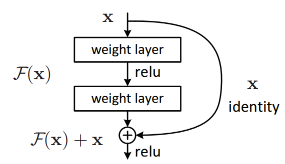

#### **Questions**

- Which problems do using skip connections solve?

- Why is a residual network called residual? 

**Your answers here**

1. Skip connections make it easier for gradients to move through deep networks, which prevents issues with vanishing or exploding gradients. They also allow layers to be “skipped” if they’re not helpful, keeping performance strong. Skip connections help carry low-level features (like edges or textures) from earlier layers directly to later layers. This means that deeper layers don’t have to learn these simple features again, and can instead focus on combining them into higher-level, complex features.

2. It’s called “residual” because each block learns the residual (difference) between the input and the desired output. Instead of learning a full transformation, the network just learns the small “extra” adjustment needed. This makes training faster and more effective.

#### **TODO**

- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet

- write a class **ResNet(nn.Module)** where you define the model

- Train the model and plot results

- Train another model by disable residual connections and compare performance

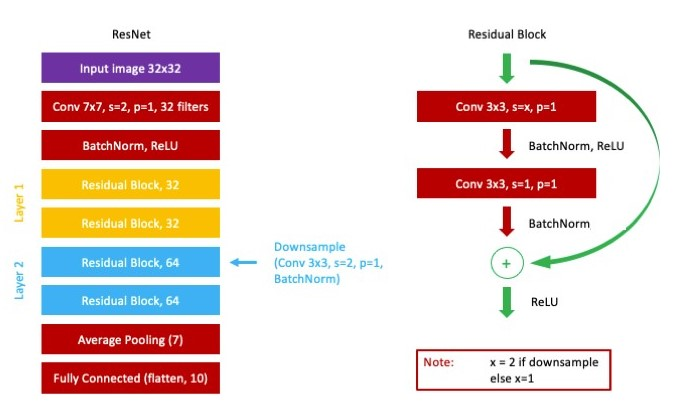

**Hints**



- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).

- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.

- The average-pooling layer has kernel size 7.

- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.

32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

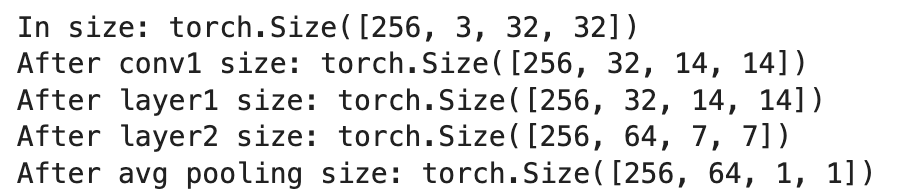


In [20]:
# TODO: Write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet
class ResidualBlock(nn.Module):
    def __init__(self, n_in, n_out, stride, residual = True):
        super().__init__()
        self.residual = residual
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(n_in, n_out, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(n_out),
            nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(n_out, n_out, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_out)
        )
        
        if n_in != n_out or stride != 1:
            self.projection = nn.Conv2d(n_in, n_out, kernel_size=1, stride=stride, padding=0)
            # Decrease in tensor size to match when downsampling
        else:
            self.projection = nn.Identity()  # No change if dimensions match

        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = self.projection(x)  
        x = self.conv1(x) 
        x = self.conv2(x) 
        if self.residual:
            x += shortcut
        return self.relu(x)  

In [21]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_out, residual = True):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(n_in, 32, kernel_size=7, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.layer1 = nn.Sequential( 
            ResidualBlock(32, 32, stride=1, residual=residual), 
            ResidualBlock(32, 32, stride=1, residual=residual) )
        
        self.layer2 = nn.Sequential( 
            ResidualBlock(32, 64, stride=2, residual=residual), 
            ResidualBlock(64,64, stride=1, residual=residual) )
        
        self.avg_pooling = nn.AdaptiveAvgPool2d((1, 1))  
        self.linear = nn.Linear(64, n_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pooling(x)
        x = torch.flatten(x, start_dim=1)  # Flatten to (batch_size, 128)
        x = self.linear(x)
        return x

In [22]:
ResNet_model = ResNet(3, 10).to(device)

In [23]:
num_epochs = 30
optimizer = optim.Adam(ResNet_model.parameters(), lr = 0.01)
    
train_losses, val_losses, train_accs, val_accs, confusion_matrix = func.run_training(ResNet_model, 
            optimizer, 
            loss_function, 
            device, 
            num_epochs, 
            train_dataloader = trainloader, 
            val_dataloader = valloader, 
            early_stopper=None, 
            verbose=False)

Finished training after 356 seconds.


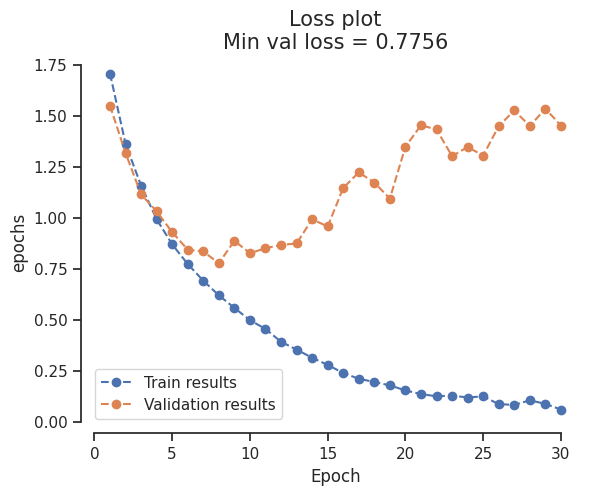

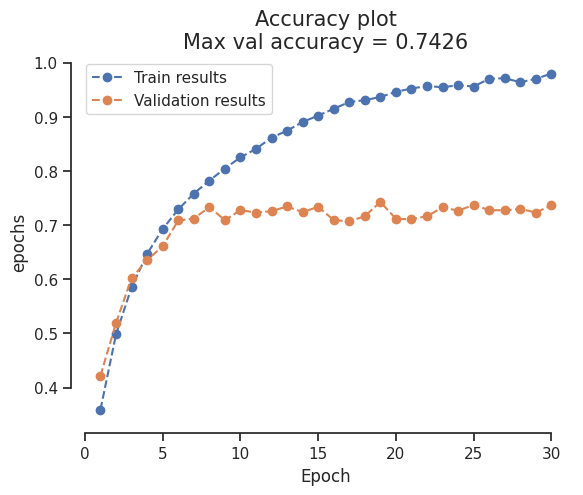

In [24]:
func.plot(f'Loss plot\nMin val loss = {round(min(val_losses),4)}' ,'epochs', 
     train_losses, val_losses)

func.plot(f'Accuracy plot\nMax val accuracy = {max(val_accs)}' ,'epochs', 
     train_accs, val_accs)

Finished training after 359 seconds.


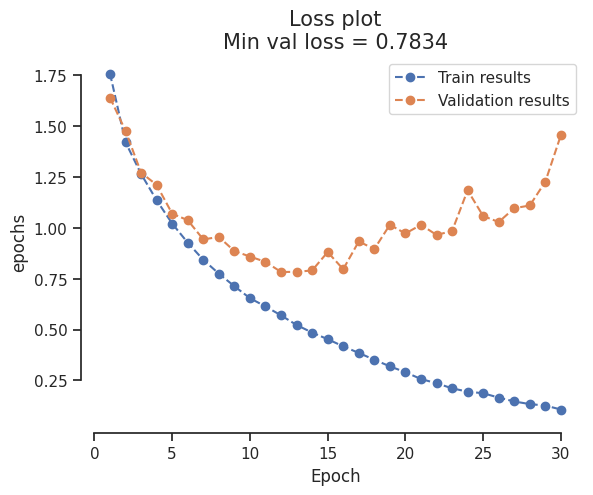

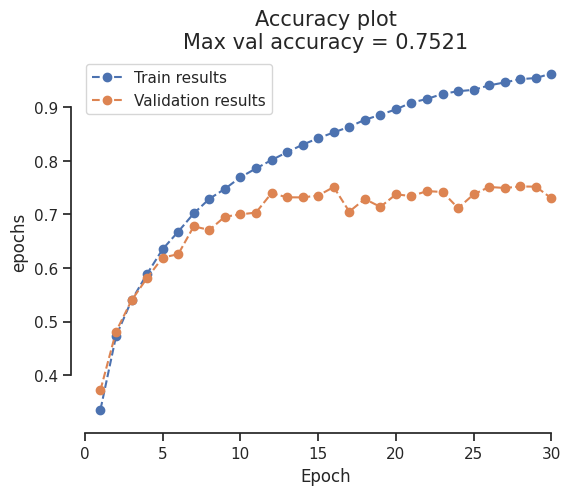

In [25]:
ResNet_model = ResNet(3, 10, False).to(device)
num_epochs = 30
optimizer = optim.Adam(ResNet_model.parameters(), lr = 0.01)
    
train_losses, val_losses, train_accs, val_accs, confusion_matrix = func.run_training(ResNet_model, 
            optimizer, 
            loss_function, 
            device, 
            num_epochs, 
            train_dataloader = trainloader, 
            val_dataloader = valloader, 
            early_stopper=None, 
            verbose=False)

func.plot(f'Loss plot\nMin val loss = {round(min(val_losses),4)}' ,'epochs', 
     train_losses, val_losses)

func.plot(f'Accuracy plot\nMax val accuracy = {max(val_accs)}' ,'epochs', 
     train_accs, val_accs)

In [26]:
# TODO: Train ResNet using the architecture laid out in the comments and figures above. Plot loss and accuracy for training and validation set.

In [27]:
# TODO: Train another model by disabling all residual connections. Plot loss and accuracy curves for training and validation set.

#### **Questions**

- Does using residual connections result in better performance in this exercise? If yes, why? If not, when would the benefit of using ResNet be most visible?

- In deeper networks, how would you expect residual blocks to influence training time? why?

- Compare the performance and training time of your ResNet with the CNNs you trained in the previous section.

**Your answers here**

1. In this case, residual connections don’t improve performance. Residual connections are beneficial for deeper networks because they help preserve information across layers, allowing the model to learn both low- and high-level features more effectively and prevents gradients vanishing. Also with low-resolution images (32x32), the model struggles to capture detailed features, making residuals less effective. Their benefits are clearer with high-resolution datasets, like ImageNet, and deeper models.

2. Adding residuals has minimal impact on one epoch training time, as matrix additions are fast in PyTorch. However, in deeper networks, residuals can improve gradient flow, and can reduce the total epochs needed for convergence and, thus, overall training time.

3. Traning ResNet with residuals took 356 seconds which comparable to the almost the same training time of CNN from the previous section which was 357 seconds. However we see improvement in max validation accuracy.

## 6. Explore Learning Rate Scheduling



Learning rate scheduling is a mechanism to adjust the learning rate.



*`torch.optim.lr_scheduler`* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**

- change run_training and extend to use scheduler for learning rate

- use `StepLR` (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.



#### **Questions**



- Try step size 1, gamma 0.1

    - How does it change the learning rate?

    - what do you observe regarding performance?

- Try step size 1, gamma 0.9, what do you observe?

    - How does it change the learning rate?

    - what do you observe regarding performance?

- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

**Step size 1, Gamma 0.1**

With a step size of 1 and gamma set to 0.1, the learning rate decreases rapidly by multiplying the current learning rate by 0.1 every epoch. This means the learning rate is reduced to 10% of its previous value at each step.

The rapid decrease in learning rate causes it to become too small too quickly. This premature decay prevents the model from further optimizing effectively, leading to fluctuations in accuracy around 0.5 for the remaining epochs.

**Step size 1, Gamma 0.9**

With a gamma of 0.9, the learning rate decreases more gradually. Instead of a drastic reduction, the learning rate decreases by 10% each epoch. This slower decay allows the model to maintain a higher learning rate longer during training.

It causes a subtle change in the learning rate which helped for the loss to dcereases slowly and the accuracy reaches to over 0.7 by less than 15 epochs and then fluctuate around 0.7 for the rest of the epochs.

**Conclusion**

- Step Size controls when the decay happens, and Gamma controls how aggressively the decay is applied.
- A small gamma (e.g., 0.1) causes a rapid decrease in the learning rate, which can hinder the model’s ability to make progress after a few epochs due to overly conservative updates.
- A larger gamma (e.g., 0.9) provides a more gradual decay, allowing the model to continue making meaningful updates throughout training. However, if gamma is too close to 1, it may not decrease the

In [28]:
# TODO: Change run_training (you can copy the code from setup.py here and create a new method here 
# or just change/create a new method it in the python file)

def run_training(
    model, optimizer, lr_scheduler, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False
):

    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = func.train(
            train_dataloader, optimizer, model, loss_function, device, master_bar
        ) #optimizer makes step here
        
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = func.validate(
            val_dataloader, model, loss_function, device, master_bar
        )

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')

        lr_scheduler.step() #step of scheduler, decreasing LR
        
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


Finished training after 360 seconds.


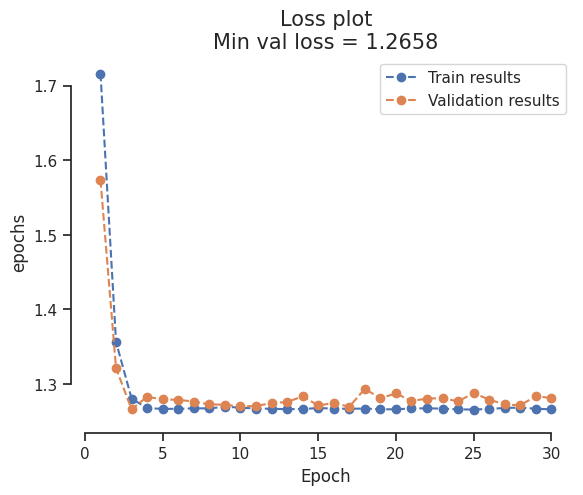

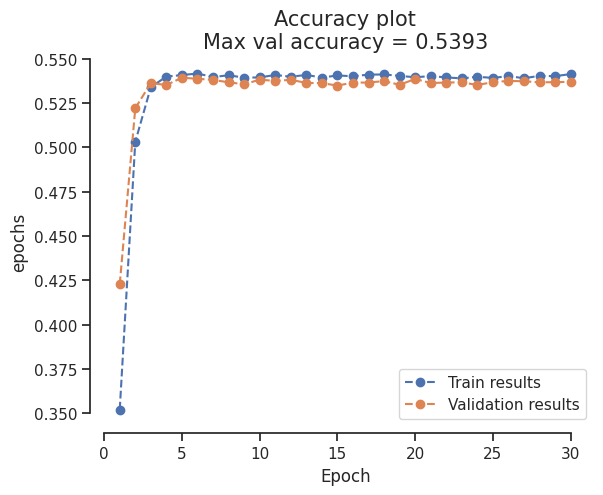

In [29]:
# TODO: Train and plot with step size 1, gamma 0.1
num_epochs = 30
learning_rate = 0.01

ResNet_model = ResNet(3, 10).to(device)
optimizer = optim.Adam(ResNet_model.parameters(), lr = learning_rate)
scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1, last_epoch=-1)
    
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(ResNet_model, 
            optimizer,
            scheduler1,                                                                     
            loss_function, 
            device, 
            num_epochs, 
            train_dataloader = trainloader, 
            val_dataloader = valloader, 
            early_stopper=None, 
            verbose=False)

func.plot(f'Loss plot\nMin val loss = {round(min(val_losses),4)}' ,'epochs', 
     train_losses, val_losses)

func.plot(f'Accuracy plot\nMax val accuracy = {max(val_accs)}' ,'epochs', 
     train_accs, val_accs)

Finished training after 358 seconds.


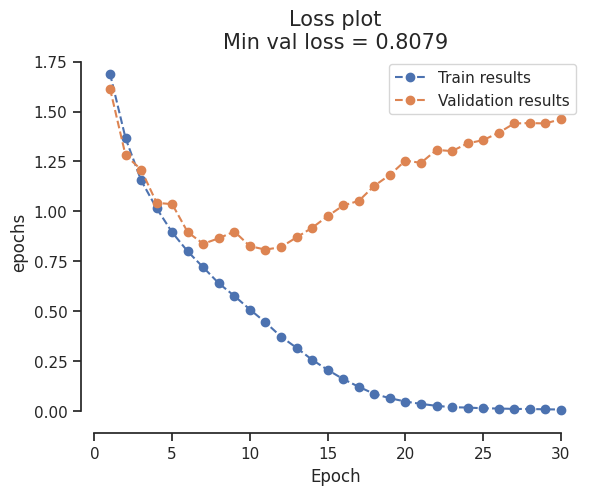

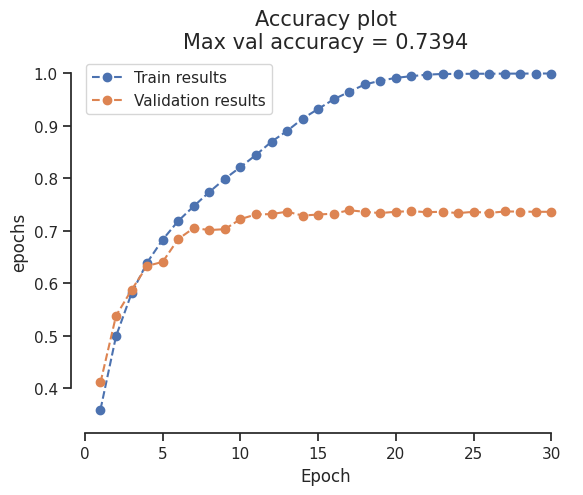

In [30]:
# TODO: Train and plot with step size 1, gamma 0.9
num_epochs = 30
learning_rate = 0.01

ResNet_model = ResNet(3, 10).to(device)
optimizer = optim.Adam(ResNet_model.parameters(), lr = learning_rate)
scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9, last_epoch=-1)
    
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(ResNet_model, 
            optimizer,
            scheduler1,                                                                     
            loss_function, 
            device, 
            num_epochs, 
            train_dataloader = trainloader, 
            val_dataloader = valloader, 
            early_stopper=None, 
            verbose=False)

func.plot(f'Loss plot\nMin val loss = {round(min(val_losses),4)}' ,'epochs', 
     train_losses, val_losses)

func.plot(f'Accuracy plot\nMax val accuracy = {max(val_accs)}' ,'epochs', 
     train_accs, val_accs)

#### **TODO** 



Use step size 15, gamma 0.1. Train for 30 epochs.

Finished training after 359 seconds.


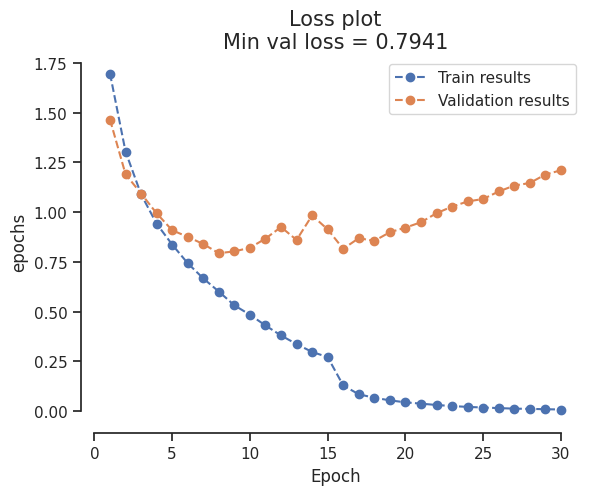

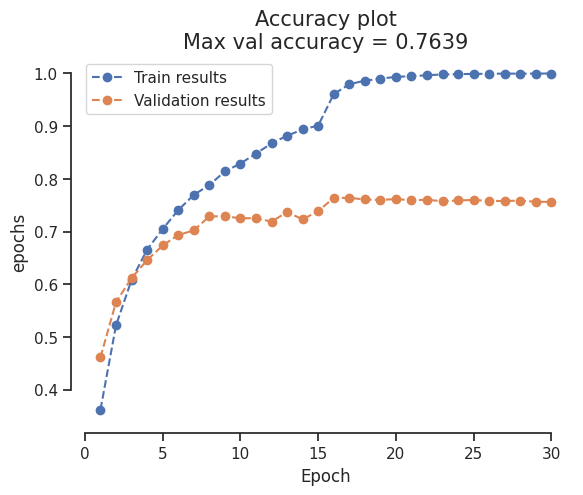

In [31]:
# TODO: Train and plot with step size 15, gamma 0.1, 30 epochs.

num_epochs = 30
learning_rate = 0.01

ResNet_model = ResNet(3, 10).to(device)
optimizer = optim.Adam(ResNet_model.parameters(), lr = learning_rate)
scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer, 15, gamma=0.1, last_epoch=-1)
    
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(ResNet_model, 
            optimizer,
            scheduler1,                                                                     
            loss_function, 
            device, 
            num_epochs, 
            train_dataloader = trainloader, 
            val_dataloader = valloader, 
            early_stopper=None, 
            verbose=False)

func.plot(f'Loss plot\nMin val loss = {round(min(val_losses),4)}' ,'epochs', 
     train_losses, val_losses)

func.plot(f'Accuracy plot\nMax val accuracy = {max(val_accs)}' ,'epochs', 
     train_accs, val_accs)

#### **Questions**

- Does it improve performance?

- What can you observe in the plots?

**Your answers here**

When we're using the step_size=15 it means that we're changing the learning rate every 15 epochs.

Comapring to last model, we can see that we get an instant boost in accuracy as we're changing the learning rate and we reach to 0.75 accuracy within a few epochs then the model slightly decreases within the remaining epochs to 0.7 accuracy.

## 7. LR-Scheduling _(Optional)_

#### TODO _(Optional)_

- try two more scheduler: ExponentialLR and ReduceLROnPlateau 

- vary the parameters, which work best?

- does it improve performance compared to no scheduler?

- does it improve performance compared to StepLR?

In [ ]:
# TODO (Optional): Train and plot with different schedulers

**Your answers here**